In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns


In [13]:
raw_data = pd.read_csv(r'/Users/michaelschaid/GitHub/credit_modeling/data/loans_2007.csv', low_memory=False)

In [108]:
def clean_loans(df):
    
    def find_cols_with_missing_data(_df, threshold):
        """Returns a list of columns with missing data over specified threshold"""
        return [col for col in _df.columns if _df[col].isnull().sum() > (_df.shape[0]*threshold)]
    
    def find_cols_with_single_val(_df):
        """ returns a list of columns with single unique values"""
        non_uniuqe_vals = _df.nunique(dropna= True) ==1 
        return [non_uniuqe_vals.index[i] for i,col in enumerate(non_uniuqe_vals) if col == True]
    
    missing_data_cols = find_cols_with_missing_data(df, threshold = 0.5)
    non_uniq_cols = find_cols_with_single_val(df)

    data_leak_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt','total_pymnt_inv', 'total_rec_prncp',
                      'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                      'funded_amnt', 'funded_amnt_inv','issue_d', 'pymnt_plan','last_pymnt_d', 'last_pymnt_amnt', 'int_rate']
    
    non_useful_cols = ['title','emp_title', 'last_credit_pull_d', 'earliest_cr_line','addr_state']
    edited_cols = ['verification_status', 'sub_grade', 'id', 'member_id','verification_status', 'zip_code', 'addr_state']
    
    columns_to_drop = [*missing_data_cols, *data_leak_cols, *edited_cols, *non_uniq_cols, *non_useful_cols]
        
    ordinal_grade_type = pd.CategoricalDtype(categories = sorted(df.grade.dropna().unique()), ordered = True)
    
    return(
        df
        .iloc[:-2]
        .assign(purpose = lambda df_: df_.purpose.astype('category'),
                home_ownership = lambda df_: df_.home_ownership.astype('category'),
                grade = lambda df_: df_.grade.astype(ordinal_grade_type),
                emp_length = lambda df_: df_.emp_length.str.replace('\D', '', regex = True).dropna().astype(int),
                verification_status = lambda df_: df_.verification_status.astype('category'),
                revol_util = lambda df_: df_.revol_util.str.replace('%', '').astype(float)
                )
        .drop(columns = columns_to_drop)
        .dropna()
        .query("loan_status == 'Fully Paid' or loan_status == 'Charged Off'")
        .replace(
            {
            "loan_status": {"Fully Paid": 1, "Charged Off": 0},
            "term":{" 36 months": 0, " 60 months": 1}
            }
            )

        )
    
loans = clean_loans(raw_data)
loans

    

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,dti,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.0,0,162.87,B,10.0,RENT,24000.0,1,credit_card,27.65,...,1.0,3.0,0.0,13648.0,83.7,9.0,0.0,0.0,0.0,0.0
1,2500.0,1,59.83,C,1.0,RENT,30000.0,0,car,1.00,...,5.0,3.0,0.0,1687.0,9.4,4.0,0.0,0.0,0.0,0.0
2,2400.0,0,84.33,C,10.0,RENT,12252.0,1,small_business,8.72,...,2.0,2.0,0.0,2956.0,98.5,10.0,0.0,0.0,0.0,0.0
3,10000.0,0,339.31,C,10.0,RENT,49200.0,1,other,20.00,...,1.0,10.0,0.0,5598.0,21.0,37.0,0.0,0.0,0.0,0.0
5,5000.0,0,156.46,A,3.0,RENT,36000.0,1,wedding,11.20,...,3.0,9.0,0.0,7963.0,28.3,12.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39631,4800.0,0,155.52,C,1.0,RENT,35000.0,1,debt_consolidation,7.51,...,0.0,11.0,1.0,5836.0,68.7,12.0,0.0,0.0,1.0,0.0
39642,7000.0,0,227.82,C,3.0,MORTGAGE,63500.0,1,debt_consolidation,8.50,...,1.0,9.0,1.0,14930.0,79.0,21.0,0.0,0.0,1.0,0.0
39692,9000.0,0,301.04,D,8.0,MORTGAGE,39000.0,0,debt_consolidation,5.08,...,3.0,9.0,1.0,26233.0,62.9,37.0,0.0,0.0,1.0,0.0
39735,15450.0,0,507.46,C,2.0,MORTGAGE,40000.0,0,debt_consolidation,13.50,...,3.0,13.0,1.0,6513.0,34.3,29.0,0.0,0.0,1.0,0.0


In [117]:
def concat_dummies(df, cols):
    dummy_df = pd.get_dummies(df[cols])
    return (
        pd.concat([df, dummy_df], axis=1)
        .drop(columns=cols)
                  )

In [118]:
loans_dum = concat_dummies(loans, cols = loans.select_dtypes('category').columns)

In [119]:
loans_dum.purpose_home_improvement.value_counts(dropna=False)

0    34230
1     2760
Name: purpose_home_improvement, dtype: int64

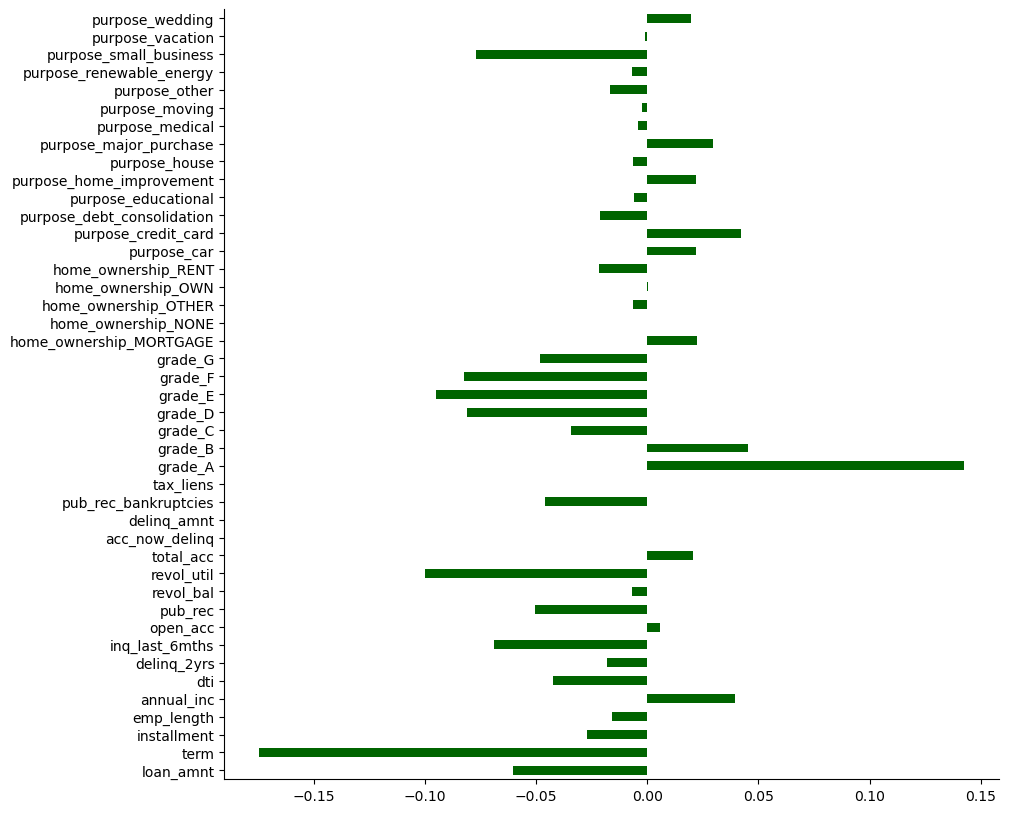

In [132]:
loan_corr = loans_dum.corr()['loan_status'].drop(index='loan_status')
loan_corr.plot.barh(color='darkgreen', figsize=(10,10))
sns.despine()


(36990, 21)